In [1]:
import numpy as np
import pandas as pd
import math
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, make_scorer, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
from scipy.optimize import minimize_scalar

In [2]:
df_full = pd.read_csv("https://raw.githubusercontent.com/ArnoMac/weatherAUS/main/weatherAUS_Kapy_v2.csv", parse_dates=['Date'], index_col=0)
# On enlève les features constantes et inutiles
df = df_full.iloc[:, :24]
df = df.drop(columns=['RainTomorrow', 'DayOfYear', 'Month', 'Latitude', 'Longitude'])
# On enlève les features classées comme non pertinentes a posteriori par le modèle ARIMA.
df = df.drop(columns=['DeltaH_2d', 'DeltaH_3d', 'DeltaP_3d', 'diffWind3pm9am'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 0 to 145459
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    145460 non-null  datetime64[ns]
 1   Location                145460 non-null  object        
 2   Rainfall                142199 non-null  float64       
 3   WindGustSpeed           135197 non-null  float64       
 4   Temp9am                 144286 non-null  float64       
 5   diffTempMinMax          144035 non-null  float64       
 6   diffPressure9am3pm      130171 non-null  float64       
 7   Pressure                130656 non-null  float64       
 8   DeltaP_1d               130542 non-null  float64       
 9   DeltaP_2d               130494 non-null  float64       
 10  diffHimidity9am3pm      140186 non-null  float64       
 11  Humidity                143573 non-null  float64       
 12  DeltaH_1d               143171

In [3]:
def plot_confusion_matrix(y_true, y_pred, display_labels):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=display_labels)
    #disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', display_labels=display_labels, values_format='.3g')
    disp.figure_.set(figwidth=3, figheight=3)
    plt.show()

In [4]:
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [54]:
location = 'Albury'
#location = 'Uluru'
df_1 = df[df['Location']==location]

In [55]:
# On enlève les 29 février des années bisextiles pour avoir une période entière de 365 jours pour SARIMA.
df_1 = df_1[(df_1['Date'].dt.month!=2)|(df_1['Date'].dt.day!=29)]

In [56]:
# On indexe sur la date pour avoir une série temporelle.
df_1 = df_1.set_index('Date')
df_1 = df_1.drop(columns='Location')

In [57]:
print("Start date =", df_1.index.min(), ", end date =", df_1.index.max())

Start date = 2008-12-01 00:00:00 , end date = 2017-06-25 00:00:00


In [58]:
# On réindexe avec un index temporel complet.
new_index = pd.date_range(start=df_1.index.min(), end=df_1.index.max(), freq='D')
org_index = df_1.index.copy()
df_1 = df_1.reindex(index=new_index)

In [59]:
# On bouche les NaN par interpolation linéaire.
df_1 = df_1.interpolate(method='linear', axis=0)

In [60]:
# On décale la feature 'Rainfall' d'un cran pour qu'elle devienne 'RainfallTomorrow'
df_1['Rainfall'] = df_1['Rainfall'].shift(-1)
df_1 = df_1.dropna()

In [61]:
# On sélectionne les features à normaliser.
cols_to_scale = list(df_1.columns[2:].values)
cols_to_scale.remove('WindDirInfluence')  # déjà normalisé
print(cols_to_scale)

['Temp9am', 'diffTempMinMax', 'diffPressure9am3pm', 'Pressure', 'DeltaP_1d', 'DeltaP_2d', 'diffHimidity9am3pm', 'Humidity', 'DeltaH_1d', 'consecutiveRainingDays']


In [62]:
# Split train/test temporel.
df_train = df_1[(df_1.index>='2011-07-01')&(df_1.index<'2016-07-01')]
df_test = df_1[df_1.index>='2016-07-01']

In [63]:
X_train = df_train.drop(columns='Rainfall')
y_train = df_train['Rainfall']
X_test = df_test.drop(columns='Rainfall')
y_test = df_test['Rainfall']

In [64]:
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# La transformation log(1+x) sur 'Rainfall' donne de bons résultats.
y_train_scaled = np.log1p(y_train)
y_test_scaled = np.log1p(y_test)

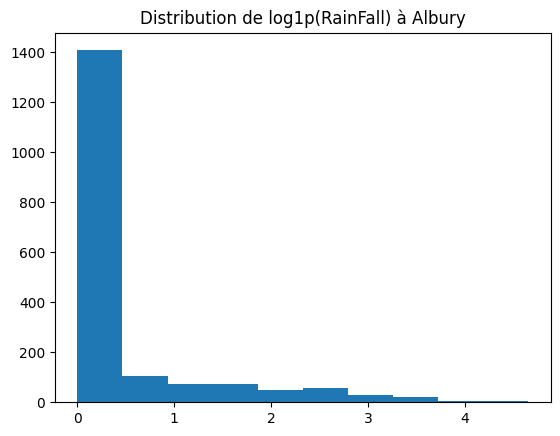

In [65]:
plt.hist(y_train_scaled)
plt.title('Distribution de log1p(RainFall) à ' + location)
plt.show()

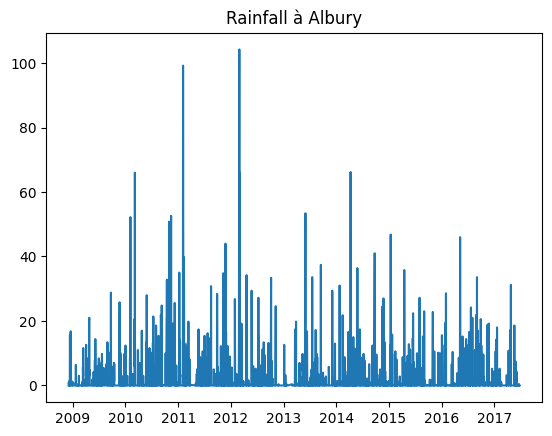

In [66]:
plt.plot(df_1['Rainfall'])
plt.title('Rainfall à ' + location)
plt.show()

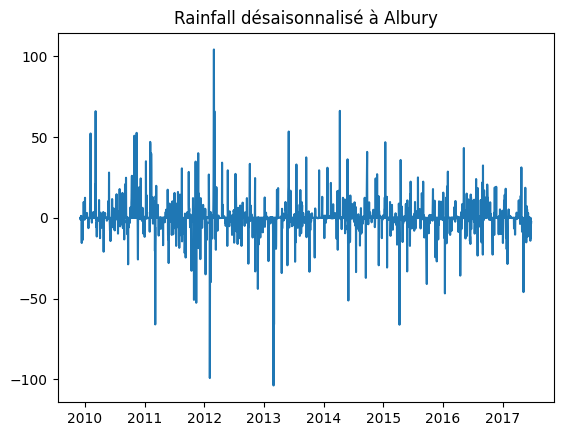

In [67]:
plt.plot(df_1['Rainfall'].diff(365))
plt.title('Rainfall désaisonnalisé à ' + location)
plt.show()

##Estimation des paramètres ARIMA

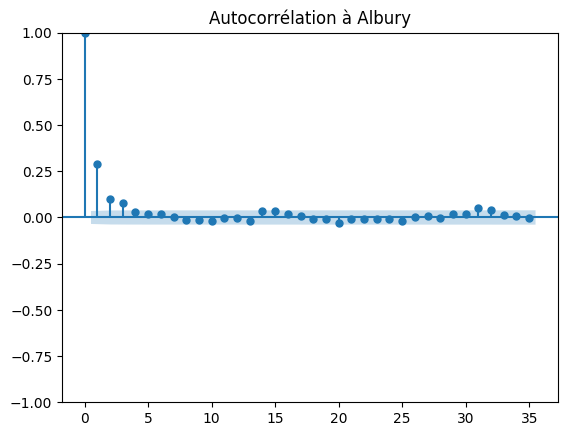

In [70]:
tsa.plot_acf(df_1['Rainfall'].dropna())
plt.title('Autocorrélation à ' + location)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


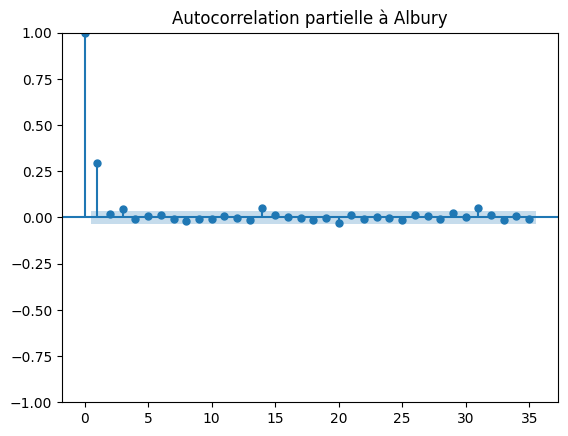

In [69]:
tsa.plot_pacf(df_1['Rainfall'].dropna())
plt.title('Autocorrélation partielle à ' + location)
plt.show()

Cela correspond à un modèle AR(1) sans différentiation.

##Estimation des paramètres ARIMA saisonniers

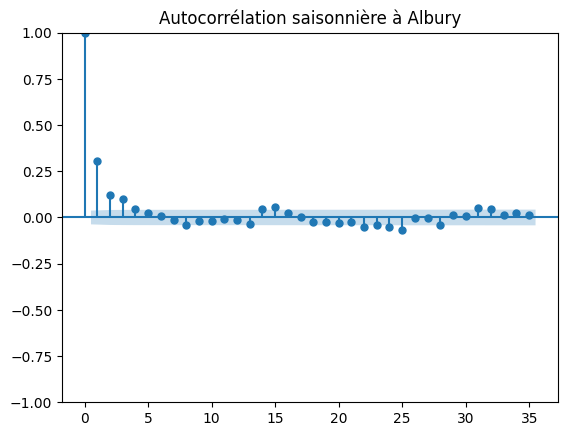

In [71]:
tsa.plot_acf(df_1['Rainfall'].diff(365).dropna())
plt.title('Autocorrélation saisonnière à ' + location)
plt.show()

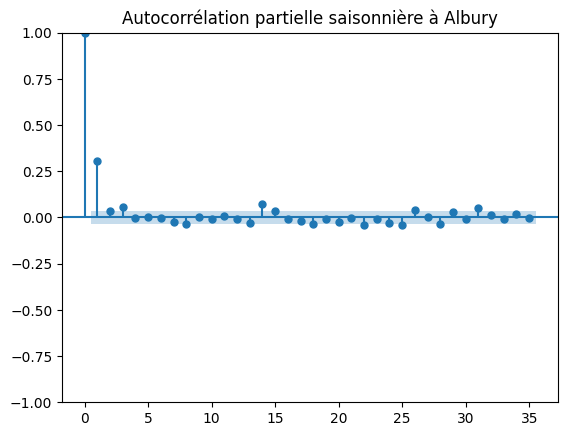

In [72]:
tsa.plot_pacf(df_1['Rainfall'].diff(365).dropna())
plt.title('Autocorrélation partielle saisonnière à ' + location)
plt.show()

Là encore, on voit la signature d'un modèle AR(1).

On va cependant choisir un modèle SARIMA(1,0,0)(0,1,1)365 pour des questions de performance de convergence et de qualité de résultat expérimental.

In [74]:
# Compte tenu de la très longue période saisonnière (365), il faut utiliser un modèle particulier avec des paramètres de fit
# très précis. Voir https://stackoverflow.com/questions/61548583/why-sarima-has-seasonal-limits
# ATTENTION : le calcul est long (plusieurs minutes).
modelx = sm.tsa.arima.ARIMA(y_train_scaled, X_train_scaled, order=(1,0,0), seasonal_order=(0, 1, 1, 365))
resultx = modelx.fit(method='innovations_mle', low_memory=True, cov_type='none')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


In [75]:
resultx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Rainfall   No. Observations:                 1827
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 365)   Log Likelihood               -1636.031
Date:                             Sun, 09 Jul 2023   AIC                           3302.061
Time:                                     15:41:55   BIC                           3381.375
Sample:                                 07-01-2011   HQIC                          3331.646
                                      - 06-30-2016                                         
Covariance Type:                      Not computed                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
WindGustSpeed              0.0109        nan        nan        nan         nan         nan
Temp9am                    0.0532        nan        nan        nan         nan         nan
diffTempMinMax            -0.2501        nan        nan        nan         nan         nan
diffPressure9am3pm        -0.2550        nan        nan        nan         nan         nan
Pressure                  -0.1444        nan        nan        nan         nan         nan
DeltaP_1d                  0.0293        nan        nan        nan         nan         nan
DeltaP_2d                  0.0168        nan        nan        nan         nan         nan
diffHimidity9am3pm         0.0255        nan        nan        nan         nan         nan
Humidity                   0.3531        nan        nan        nan         nan         nan
DeltaH_1d                  0.0517        nan        nan        nan         nan         nan
WindDirInfluence           0.4733        nan        nan        nan         nan         nan
consecutiveRainingDays    -0.0828        nan        nan        nan         nan         nan
ar.L1                      0.2635        nan        nan        nan         nan         nan
ma.S.L365                 -0.6916        nan        nan        nan         nan         nan
sigma2                     0.4696        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               188.26
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.31
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [76]:
# Prédiction sur la période de test
y_pred_scaled = resultx.forecast(steps=X_test_scaled.shape[0], exog=X_test_scaled)
y_pred = np.expm1(y_pred_scaled)

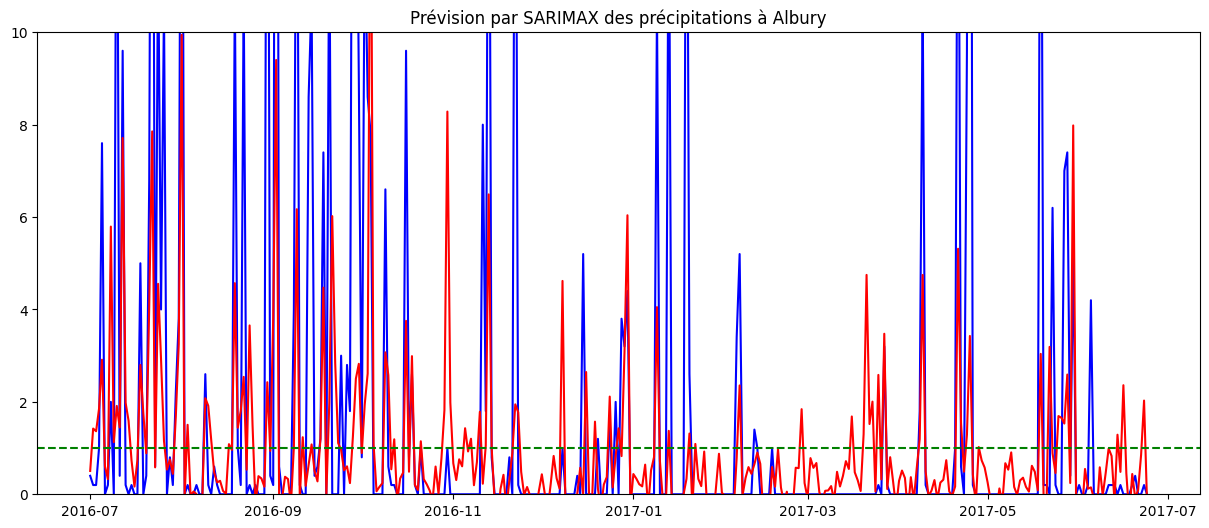

In [77]:
plt.figure(figsize=(15,6))
plt.plot(y_test, color='blue')
plt.plot(y_pred, color='red')
plt.ylim(0,10)
plt.axhline(y=1, color='green', ls='--')
plt.title('Prévision par SARIMAX des précipitations à ' + location)
plt.show()

MAE = 1.7404
              precision    recall  f1-score   support

       False       0.94      0.82      0.88       292
        True       0.50      0.79      0.61        67

    accuracy                           0.81       359
   macro avg       0.72      0.80      0.74       359
weighted avg       0.86      0.81      0.83       359



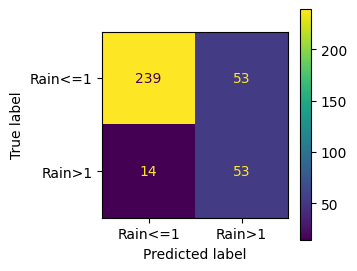

In [26]:
true_pred_index = y_test.index.intersection(org_index) # pour faire le calcul sur les valeurs connues, et pas sur les valeurs interpolées.
y_pred_bool = (y_pred[true_pred_index] > 1)
y_test_bool = (y_test[true_pred_index] > 1)
print('MAE =', round(mean_absolute_error(y_test, y_pred), 4))
print(classification_report(y_test_bool, y_pred_bool))
plot_confusion_matrix(y_test_bool, y_pred_bool, display_labels=['Rain<=1', 'Rain>1'])

##Modèle ARIMA avec features de Fourier
En suivant les indications suivantes : https://robjhyndman.com/hyndsight/longseasonality/, on va utiliser un modèle ARIMA sans saisonnalité auquel on adjoint des features de Fourier pour tenir compte de la saisonnalité longue.

In [27]:
class RainfallPredictor:
    """
    Cette classe prédit la variable Rainfall au moyen d'un modèle ARIMA.

    Attributs
    ---------
    location : str
        le lieu à prédire
    result_ : ARIMAResult
        le résultat de l'entraînement du modèle ARIMA
    duan_smearing_factor_ : float
        le facteur correctif de Duan
    f1_ : float
      le score F1 non ajusté sur l'ensemble de test
    mae_ : float
      l'erreur absolue moyenne sur Rainfall de l'ensemble de test
    mse_ : float
      l'erreur quadratique moyenne sur Rainfall de l'ensemble de test
    threshold_ : float
        le seuil de détection de pluie ajusté sur l'ensemble d'entraînement pour optimiser le score F1
    optimized_f1_ : float
        le score F1 obtenu sur l'ensemble de test en utilisant le seuil de détection de pluie ajusté sur l'ensemble d'entraînement
    optimized_f1_train_ : float
        le score F1 obtenu en utilisant le seuil de détection de pluie ajusté sur l'ensemble d'entraînement
    threshold_test_ : float
        le seuil de détection de pluie ajusté sur l'ensemble de test pour optimiser le score F1
    optimized_f1_test_ : float
        le score F1 obtenu en utilisant le seuil de détection de pluie ajusté sur l'ensemble de test.
        Ce score est le plus haut score possible et permet de comparer le score F1 obtenu sur l'ensemble de test avec un modèle
        entraîné sur l'ensemble d'entraînement

    Méthodes
    --------
    fit(df, location, n_harmonics=2, n_lead=1, start_train_date='2011-07-01', start_test_date='2016-07-01', maxiter=None)
        Entraîne le modèle à partir des données d'entraînement

    transform_exog(self, X)
        Transforme les données brutes en données acceptables par la méthode forecast()

    test(self, duan_smearing = False, use_f1_optimization = True, use_train_set = False)
        Applique le modèle entraîné aux données de test ou d'entraînement

    forecast(self, steps, exog, duan_smearing = False)
        Applique le modèle pour faire des prédictions dans l'avenir
    """

    def __init__(self):
        self.threshold_max = 1.5
        return

    def __fourier_features(self, index, dates, start_date, period, order):
        """
        Paramètres
        ----------
        index : Index
            L'index à utiliser pour le DataFrame résultat
        dates : Series
            Les dates pour lesquelles il faut calculer les features de Fourier
        start_date : str
            La date correspondant au zéro du calcul des features de Fourier
        period : float
            La période de la série de Fourier
        order : int
            Le nombre d'harmoniques à générer

        Retour
        ------
        Un DataFrame avec 2 features par harmonique
        """

        time = (dates - start_date).days
        k = 2 * np.pi * (1 / period) * time
        features = {}
        for i in range(1, order + 1):
            features.update({
                f"sin_{period}_{i}": np.sin(i * k),
                f"cos_{period}_{i}": np.cos(i * k),
            })
        return pd.DataFrame(features, index=index)

    def fit(self, df, location, n_harmonics=2, n_lead=1, start_train_date='2011-07-01', start_test_date='2016-07-01', maxiter=None):
        """
        Paramètres
        ----------
        df : DataFrame
            Données de la série temporelle indexées selon le temps
        location : str
            Ville où effectuer l'entraînement
        n_harmonics : int
            Nombre d'harmoniques de Fourier à ajouter comme features
        n_lead : int
            Indice du jour à prédire après le dernier jour
        start_train_date : str
            Date où commence l'ensemble d'entraînement
        start_test_date : str
            Date où se termine l'ensemble d'entraînement et où commence l'ensemble de test
        maxiter : int, optionnel
            Nombre d'itérations pour entraîner le modèle ARIMA
        """

        self.location = location
        self.n_harmonics = n_harmonics

        # Création de la série temporelle
        df_1 = df[df['Location']==location]
        df_1 = df_1.set_index('Date')
        df_1 = df_1.drop(columns='Location')

        # On enlève les lignes entèrement vides.
        df_1 = df_1[~df_1.isna().all(axis=1)]

        # On réindexe avec un index temporel complet.
        org_index = df_1.index.copy()
        new_index = pd.date_range(start=df_1.index.min(), end=df_1.index.max(), freq='D')
        df_1 = df_1.reindex(index=new_index)

        # On bouche les NaN par interpolation linéaire.
        df_1 = df_1.interpolate(method='linear', axis=0, limit_direction='both')

        # On enlève les colonnes vides
        self.cols_to_drop = list(df_1.columns[df_1.isna().any(axis=0)])
        if 'Rainfall' in self.cols_to_drop:
            self.cols_to_drop.remove('Rainfall') # on garde toujours Rainfall
        df_1 = df_1.drop(columns=self.cols_to_drop)

        # On décale Rainfall dans le temps
        df_1['Rainfall'] = df_1['Rainfall'].shift(-n_lead)
        df_1 = df_1.dropna()

        # Split train/test temporel.
        df_train = df_1[(df_1.index>=start_train_date)&(df_1.index<start_test_date)]
        df_test = df_1[df_1.index>=start_test_date]
        X_train = df_train.drop(columns='Rainfall')
        self.y_train = df_train['Rainfall']
        X_test = df_test.drop(columns='Rainfall')
        self.y_test = df_test['Rainfall']
        self.true_train_index = self.y_train.index.intersection(org_index)
        self.true_pred_index = self.y_test.index.intersection(org_index)

        has_test = (X_test.shape[0] != 0)

        # Scaling
        self.cols_to_scale = list(df_1.columns[2:].values)
        if ('WindDirInfluence' in self.cols_to_scale):
            self.cols_to_scale.remove('WindDirInfluence') # déjà normalisé
        self.scaler = StandardScaler()
        self.scaler.fit(X_train[self.cols_to_scale])
        X_train_scaled = X_train.copy()
        X_train_scaled[self.cols_to_scale] = self.scaler.transform(X_train[self.cols_to_scale])
        y_train_scaled = np.log1p(self.y_train)
        if has_test:
            X_test_scaled = X_test.copy()
            X_test_scaled[self.cols_to_scale] = self.scaler.transform(X_test[self.cols_to_scale])

        # Ajout des features de Fourier
        self.start_date = new_index[0]
        self.X_train_fourier = X_train_scaled.join(self.__fourier_features(X_train_scaled.index, df_train.index, self.start_date, 365.25, n_harmonics), how='left')
        if (has_test):
            self.X_test_fourier = X_test_scaled.join(self.__fourier_features(X_test_scaled.index, df_test.index, self.start_date, 365.25, n_harmonics), how='left')

        # Apprentissage du modèle
        model = sm.tsa.arima.ARIMA(y_train_scaled, self.X_train_fourier, order=(1,0,0))
        method_kwargs = {}
        if maxiter is not None:
            method_kwargs['maxiter'] = maxiter

        self.result_ = model.fit(method_kwargs=method_kwargs)
        self.duan_smearing_factor_ = np.exp(self.result_.resid).mean()

        if not has_test:
            return self

        # Optimisation du score F1 sur l'ensemble d'entraînement
        #pred_start = (self.X_train_fourier.shape[0] * 3) // 4
        pred_start = 0
        y_pred = self.__predict(self.X_train_fourier[pred_start:], start=pred_start)
        partial_train_index = self.true_train_index.intersection(self.y_train[pred_start:].index)

        def f1_rain_train(threshold):
            y_pred_bool = (y_pred[partial_train_index] > threshold)
            y_test_bool = (self.y_train[partial_train_index] > 1)

            return -f1_score(y_test_bool, y_pred_bool, pos_label=True)

        min_success, min_x, min_fun = self.__minimize_func(f1_rain_train)
        if min_success:
            self.threshold_ = min_x
            self.optimized_f1_train_ = -min_fun
        else:
            self.threshold_ = 1.0
            self.optimized_f1_train_ = -f1_rain_train(1.0)

        # Optimisation du score F1 sur l'ensemble de test
        pred_span = self.X_test_fourier.shape[0]
        y_pred = self.forecast(pred_span, self.X_test_fourier)

        self.mae_ = mean_absolute_error(self.y_test, y_pred)
        self.mse_ = mean_squared_error(self.y_test, y_pred)

        def f1_rain_test(threshold):
            y_pred_bool = (y_pred[self.true_pred_index] > threshold)
            y_test_bool = (self.y_test[self.true_pred_index] > 1)

            return -f1_score(y_test_bool, y_pred_bool, pos_label=True)

        self.f1_ = -f1_rain_test(1.0)
        self.optimized_f1_ = -f1_rain_test(self.threshold_)

        min_success, min_x, min_fun = self.__minimize_func(f1_rain_test)
        if (min_success):
            self.threshold_test_ = min_x
            self.optimized_f1_test_ = -min_fun
        else:
            self.threshold_test_ = 1.0
            self.optimized_f1_test_ = self.f1_

        return self

    def __minimize_func(self, f):
        """
        Cherche le minimum d'une fonction score.

        Paramètres
        ----------
        f : fonction
            la fonction à minimiser

        Retour
        ----------
        Un triplet (succès, position du minimum, valeur minimale de la fonction)
        """

        r = np.linspace(1.0, 1.5, 11)
        feval = [f(x) for x in r]
        idx = np.argmin(feval[:-1])
        if (idx == 0):
            return (True, 1.0, feval[0])
        bracket = [r[idx-1], r[idx], r[idx+1]]
        if feval[idx]>=feval[idx-1] or feval[idx]>=feval[idx+1]:
            bracket = None
        res = minimize_scalar(f, method='brent', bracket=bracket)
        if (res.success and res.x < 1.0):
            return (True, 1.0, feval[0])

        return (res.success, res.x, res.fun)

    def transform_exog(self, X):
        """
        Paramètres
        ----------
        X : DataFrame
            les données brutes à transformer

        Retour
        ----------
        Un DataFrame transformé pour être compatible avec le modèle et la méthode forecast()
        """

        X_scaled = X.copy()
        X_scaled = X_scaled.set_index('Date')
        X_scaled = X_scaled.drop(columns = self.cols_to_drop + ['Location', 'Rainfall'])
        X_scaled[self.cols_to_scale] = self.scaler.transform(X[self.cols_to_scale])
        X_fourier = X_scaled.join(self.__fourier_features(X_scaled.index, X_scaled.index, self.start_date, 365.25, self.n_harmonics), how='left')

        return X_fourier

    def test(self, duan_smearing = False, use_f1_optimization = True, use_train_set = False):
        """
        Paramètres
        ----------
        duan_smearing : bool, optionnel (défault = False)
            Indique s'il faut appliquer le facteur d'ajustement de Duan aux résultats

        Retour
        ----------
        Un 4-uple contenant les précipitations vraies (float), les précipitations prédites (float),
        les indicateurs de pluie vrais (bool) et les indicateurs de pluie prédits (bool)
        """

        if use_train_set:
            X_test = self.X_train_fourier
            y_test = self.y_train
            true_index = self.true_train_index
            y_pred = self.__predict(X_test)
        else:
            X_test = self.X_test_fourier
            y_test = self.y_test
            true_index = self.true_pred_index
            pred_span = X_test.shape[0]
            y_pred = self.forecast(pred_span, X_test, duan_smearing=duan_smearing)

        threshold = self.threshold_ if use_f1_optimization else 1.0
        y_pred_bool = (y_pred[true_index] > threshold)
        y_test_bool = (y_test[true_index] > 1)

        return (y_test, y_pred, y_test_bool, y_pred_bool)

    def forecast(self, steps, exog, duan_smearing = False):
        """
        Paramètres
        ----------
        steps : int
            Le nombre de jours à prédire
        exog : DataFrame
            Les features indexés par le temps
        duan_smearing : bool, optionnel (défault = False)
            Indique s'il faut appliquer le facteur d'ajustement de Duan aux résultats

        Retour
        ----------
        Les précipitations prédites (float)
        """

        y_pred_raw = self.result_.forecast(steps=steps, exog=exog)
        return self.__adjust_prediction(y_pred_raw, duan_smearing)

    def __predict(self, exog, start=None, end=None, duan_smearing = False):
        """
        Calcule les prédictions in-sample du modèle ARIMA.

        Paramètres
        ----------
        exog : DataFrame
            Les features indexés par le temps
        start : str, optionnel (défault = None)
            La date de début des prédictions, ou None pour commencer au début des données
        end : str, optionnel (défault = None)
            La date de fin des prédictions, ou None pour terminer à la fin des données
        duan_smearing : bool, optionnel (défault = False)
            Indique s'il faut appliquer le facteur d'ajustement de Duan aux résultats

        Retour
        ----------
        Le résultat des prédictions du modèle
        """

        y_pred_raw = self.result_.predict(start=start, end=end, exog=exog)
        return self.__adjust_prediction(y_pred_raw, duan_smearing=duan_smearing)

    def __adjust_prediction(self, y_pred_raw, duan_smearing = False):
        """
        Ajuste les prédictions brutes du modèle.

        Paramètres
        ----------
        y_pred_raw : Series
            Les prédictions brutes
        duan_smearing : bool, optionnel (défault = False)
            Indique s'il faut appliquer le facteur d'ajustement de Duan aux résultats

        Retour
        ----------
        Le résultat des prédictions du modèle
        """

        if (duan_smearing):
            y_pred = np.exp(y_pred_raw) * self.duan_smearing_factor_ - 1.0
        else:
            y_pred = np.expm1(y_pred_raw)

        return np.fmax(y_pred, 0.0)


In [82]:
location = 'Albury'
predictor = RainfallPredictor()
predictor.fit(df, location, n_harmonics=1, maxiter=200) # Expérimentalement, 3 niveaux d'harmoniques suffisent.
predictor.result_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Rainfall   No. Observations:                 1827
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1653.846
Date:                Sun, 09 Jul 2023   AIC                           3341.692
Time:                        15:54:19   BIC                           3435.369
Sample:                    07-01-2011   HQIC                          3376.246
                         - 06-30-2016                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0374      0.059     -0.633      0.527      -0.153       0.078
WindGustSpeed              0.0103      0.001      8.399      0.000       0.008       0.013
Temp9am                    0.0750      0.045      1.677      0.094      -0.013       0.163
diffTempMinMax            -0.1965      0.026     -7.556      0.000      -0.248      -0.146
diffPressure9am3pm        -0.2384      0.021    -11.602      0.000      -0.279      -0.198
Pressure                  -0.1502      0.030     -4.943      0.000      -0.210      -0.091
DeltaP_1d                  0.0378      0.028      1.365      0.172      -0.016       0.092
DeltaP_2d                 -0.0034      0.028     -0.121      0.904      -0.059       0.052
diffHimidity9am3pm         0.0474      0.023      2.073      0.038       0.003       0.092
Humidity                   0.3430      0.036      9.643      0.000       0.273       0.413
DeltaH_1d                  0.0543      0.018      3.090      0.002       0.020       0.089
WindDirInfluence           0.5617      0.148      3.791      0.000       0.271       0.852
consecutiveRainingDays    -0.0744      0.022     -3.402      0.001      -0.117      -0.032
sin_365.25_1               0.0061      0.044      0.139      0.889      -0.080       0.093
cos_365.25_1              -0.0305      0.052     -0.588      0.556      -0.132       0.071
ar.L1                      0.2367      0.023     10.140      0.000       0.191       0.282
sigma2                     0.3579      0.009     38.444      0.000       0.340       0.376
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1630.50
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.39
Prob(H) (two-sided):                  0.44   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

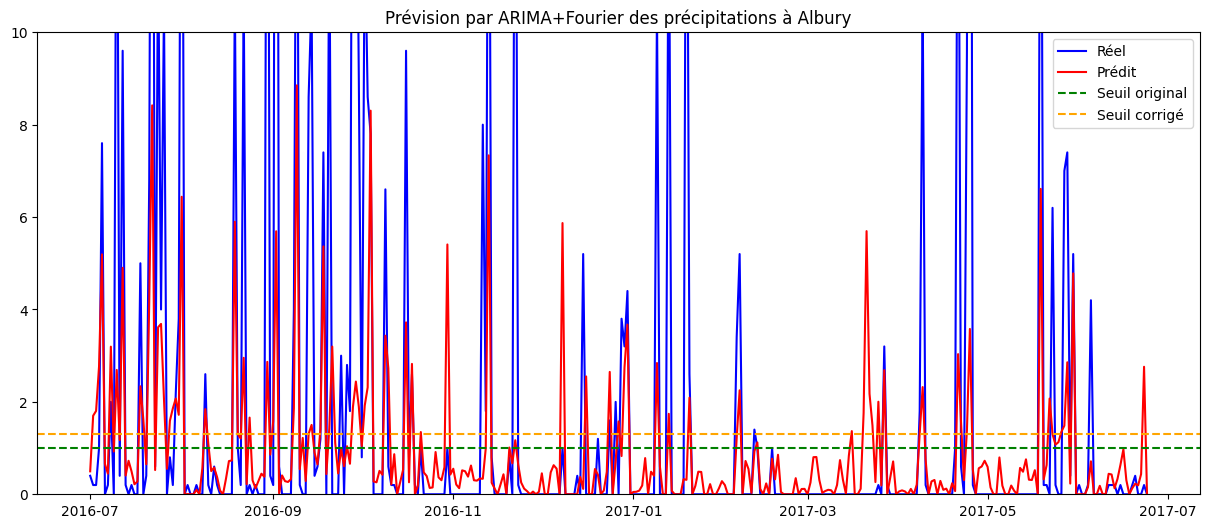

In [87]:
y_test_rainfall, y_pred_rainfall, y_test_raintomorrow, y_pred_raintomorrow = predictor.test(use_f1_optimization = False)

plt.figure(figsize=(15,6))
plt.plot(y_test_rainfall, color='blue', label='Réel')
plt.plot(y_pred_rainfall, color='red', label='Prédit')
plt.ylim(0,10)
plt.axhline(y=1, color='green', ls='--', label='Seuil original')
plt.axhline(y=predictor.threshold_, color='orange', ls='--', label='Seuil corrigé')
plt.title('Prévision par ARIMA+Fourier des précipitations à ' + predictor.location)
plt.legend()
plt.show()

In [84]:
print("Erreur MAE sur Rainfall  :", round(predictor.mae_, 3))
print("Erreur RMSE sur Rainfall :", round(math.sqrt(predictor.mse_), 3))

Erreur MAE sur Rainfall  : 1.555
Erreur RMSE sur Rainfall : 4.032


Classification sans ajustement du seuil
---------------------------------------

              precision    recall  f1-score   support

       False       0.96      0.88      0.92       292
        True       0.61      0.84      0.70        67

    accuracy                           0.87       359
   macro avg       0.78      0.86      0.81       359
weighted avg       0.89      0.87      0.88       359



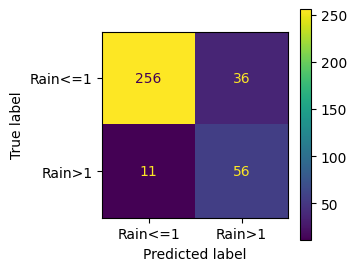

In [85]:
_, _, y_test_raintomorrow, y_pred_raintomorrow = predictor.test(use_f1_optimization = False)

print("Classification sans ajustement du seuil")
print("---------------------------------------\n")
print(classification_report(y_test_raintomorrow, y_pred_raintomorrow))
plot_confusion_matrix(y_test_raintomorrow, y_pred_raintomorrow, display_labels=['Rain<=1', 'Rain>1'])

###Ajustement du seuil de détection de pluie
Le modèle ARIMA cherche à minimiser l'écart quadratique de la fonction *ln(1+Rainfall)*, ce qui n'est pas la même chose que minimiser l'erreur sur la prédiction *Rainfall>1*.

Pour essayer de compenser l'effet de cette transformation non linéaire, on peut chercher une fonction de transfert paramétrée pour transformer la valeur de *Rainfall* prédite, puis maximiser une métrique bien choisie par optimisation des paramètres de la fonction de transfert sur l'ensemble d'entraînement.

Cependant, comme au final on ne s'intéresse qu'au test *Rainfall>1*, le problème peut se simplifier en remplaçant le test par *Rainfall>seuil* et en optimisant le paramètre *seuil* sur la métrique voulue.

Ici, on a choisi la métrique *F1 score(True)*.

Correction du seuil de Rainfall sur l'ensemble d'entraînement
-------------------------------------------------------------
Seuil corrigé : 1.314
Score F1 optimisé sur l'ensemble d'entraînement : 0.713

Classification avec ajustement du seuil
---------------------------------------

              precision    recall  f1-score   support

       False       0.94      0.91      0.93       292
        True       0.67      0.76      0.71        67

    accuracy                           0.89       359
   macro avg       0.81      0.84      0.82       359
weighted avg       0.89      0.89      0.89       359



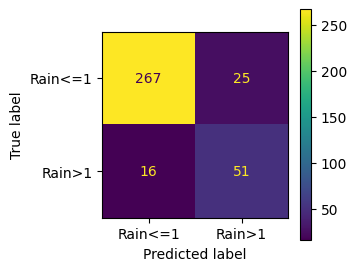

In [88]:
_, _, y_test_raintomorrow, y_pred_raintomorrow = predictor.test(use_f1_optimization = True)

print("Correction du seuil de Rainfall sur l'ensemble d'entraînement")
print("-------------------------------------------------------------")
print("Seuil corrigé :", round(predictor.threshold_, 3))
print("Score F1 optimisé sur l'ensemble d'entraînement :", round(predictor.optimized_f1_, 3))
print()
print("Classification avec ajustement du seuil")
print("---------------------------------------\n")
print(classification_report(y_test_raintomorrow, y_pred_raintomorrow))
plot_confusion_matrix(y_test_raintomorrow, y_pred_raintomorrow, display_labels=['Rain<=1', 'Rain>1'])

In [89]:
def plot_scatter_prediction(y_test_rainfall, y_pred_rainfall, threshold):
    plt.scatter(x=np.log1p(y_pred_rainfall), y=np.log1p(y_test_rainfall), alpha=0.2)
    plt.plot([0.0, 3.5], [0.0, 3.5], 'v--', alpha=0.5)
    plt.axhline(y=1.0, ls=':', c='g', alpha=0.5, label='Seuil original')
    plt.axvline(x=1.0, ls=':', c='g', alpha=0.5)
    plt.axvline(x=threshold, ls=':', c='r', alpha=1, label='Seuil corrigé')
    plt.xlim(-0.1, 3.5)
    plt.ylim(-0.1, 3.5)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')

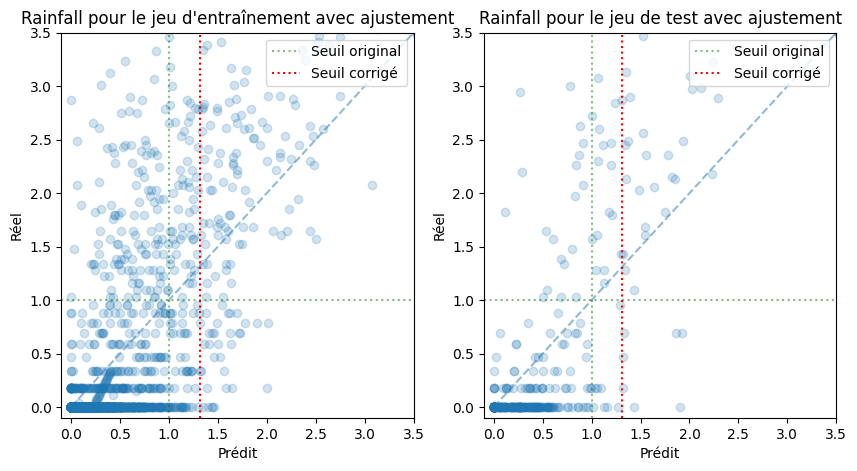

In [90]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
y_test_rainfall, y_pred_rainfall, _, _ = predictor.test(use_f1_optimization = True, use_train_set = True)
plot_scatter_prediction(y_test_rainfall, y_pred_rainfall, predictor.threshold_)
plt.legend(loc='upper right')
plt.title("Rainfall pour le jeu d'entraînement avec ajustement")
plt.subplot(122)
y_test_rainfall, y_pred_rainfall, _, _ = predictor.test(use_f1_optimization = True, use_train_set = False)
plot_scatter_prediction(y_test_rainfall, y_pred_rainfall, predictor.threshold_)
plt.legend(loc='upper right')
plt.title('Rainfall pour le jeu de test avec ajustement')
plt.show()

In [95]:
locations_f1 = {'Location':[], 'Threshold':[], 'F1_raw':[], 'F1_optim':[], 'MAE':[], 'MSE':[]}

for loc in tqdm(df['Location'].unique()):
    predictor = RainfallPredictor()
    predictor.fit(df, loc, n_harmonics=1, maxiter=300)
    locations_f1['Location'].append(loc)
    locations_f1['Threshold'].append(predictor.threshold_)
    locations_f1['F1_raw'].append(predictor.f1_)
    locations_f1['F1_optim'].append(predictor.optimized_f1_)
    locations_f1['MAE'].append(predictor.mae_)
    locations_f1['MSE'].append(predictor.mse_)

100%|██████████| 49/49 [08:54<00:00, 10.90s/it]


In [96]:
df_f1 = pd.DataFrame(data=locations_f1)
df_f1_sorted = df_f1.rename(columns={'F1_raw':'F1 non ajusté', 'F1_optim':'F1 optimisé'}) \
    .melt(id_vars='Location', value_vars=['F1 non ajusté', 'F1 optimisé'], var_name='Variable', value_name='Value') \
    .sort_values(['Variable', 'Value'], ascending=False)

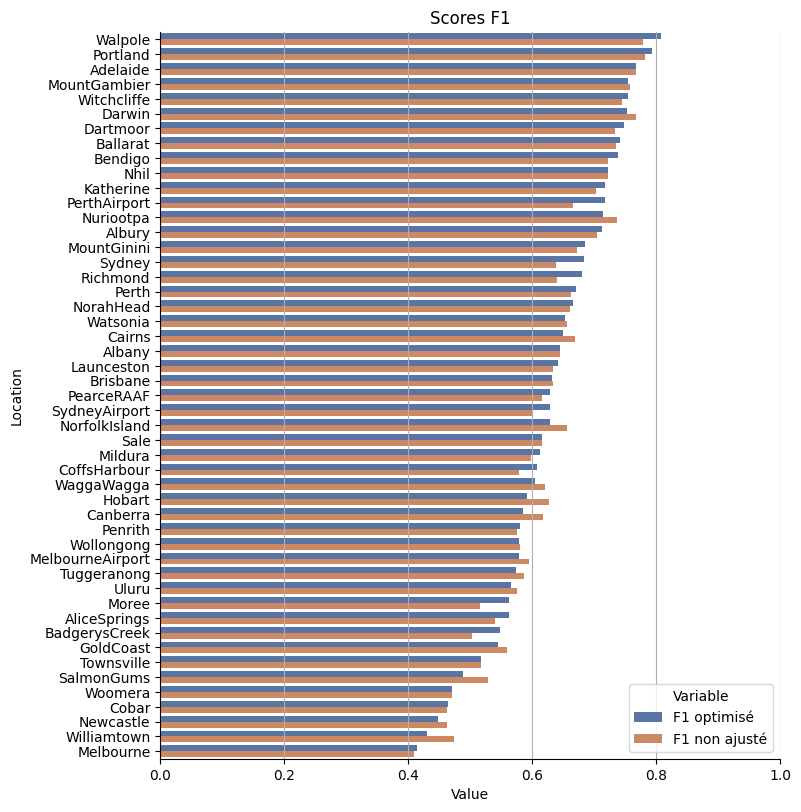

In [97]:
g = sns.catplot(df_f1_sorted, x='Value', y='Location', hue='Variable', kind='bar', height=8,
            hue_order=['F1 optimisé', 'F1 non ajusté'], legend_out=False, palette='deep')
g.axes[0].item().grid(axis='x')
plt.xlim(0.0, 1.0)
plt.title('Scores F1')
plt.show()

## Prédiction de la pluie du lendemain
L'objectif de l'exercice est de déterminer s'il pleuvra le dernier jour de la série pour chaque ville.

On va entrainer le modèle sur chaque ville sur l'ensemble des données et effectuer une prédiction pour le dernier jour.

In [98]:
locations_rainfall = {'Location':[], 'Date':[], 'Rainfall':[], 'RainTomorrow':[], 'RainTomorrowAdjusted':[], 'RainTomorrowTrue':[]}
df_i = df.fillna(method='ffill', axis=0)

for location in tqdm(df['Location'].unique()):
    last_date = df_full[df_full['Location']==location].dropna(axis=0, subset='RainTomorrow')['Date'].tail(1).item()
    predictor = RainfallPredictor()
    predictor.fit(df, location, n_harmonics=1, n_lead=1, start_test_date=last_date, maxiter=300)
    X_last = df_i[(df_i['Location']==location) & (df_i['Date']==last_date)]
    X_last_scaled = predictor.transform_exog(X_last)
    y_last_pred = predictor.forecast(1, X_last_scaled)

    rainfall_pred = y_last_pred[0].item()
    threshold = df_f1[df_f1['Location']==location]['Threshold'].item()
    rain_true = df_full[(df_full['Location']==location) & (df_full['Date']==last_date)]['RainTomorrow'].item()

    locations_rainfall['Location'].append(location)
    locations_rainfall['Date'].append(last_date)
    locations_rainfall['Rainfall'].append(rainfall_pred)
    locations_rainfall['RainTomorrow'].append(1.0 if rainfall_pred > 1.0 else 0.0)
    locations_rainfall['RainTomorrowAdjusted'].append(1.0 if rainfall_pred > threshold else 0.0)
    locations_rainfall['RainTomorrowTrue'].append(rain_true)

df_rainfall = pd.DataFrame(data=locations_rainfall)

 39%|███▉      | 19/49 [04:20<05:23, 10.79s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 63%|██████▎   | 31/49 [06:43<03:11, 10.61s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 65%|██████▌   | 32/49 [06:56<03:11, 11.29s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarn

###Prédictions brutes sur l'ensemble des villes

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        44
         1.0       0.36      1.00      0.53         5

    accuracy                           0.82        49
   macro avg       0.68      0.90      0.71        49
weighted avg       0.93      0.82      0.85        49



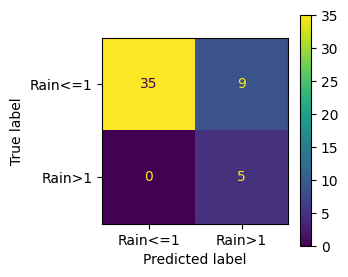

In [99]:
print(classification_report(df_rainfall['RainTomorrowTrue'], df_rainfall['RainTomorrow']))
plot_confusion_matrix(df_rainfall['RainTomorrowTrue'], df_rainfall['RainTomorrow'], display_labels=['Rain<=1', 'Rain>1'])

###Prédictions ajustées sur l'ensemble des villes

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.92        44
         1.0       0.40      0.80      0.53         5

    accuracy                           0.86        49
   macro avg       0.69      0.83      0.72        49
weighted avg       0.92      0.86      0.88        49



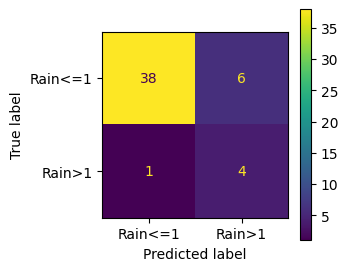

In [100]:
print(classification_report(df_rainfall['RainTomorrowTrue'], df_rainfall['RainTomorrowAdjusted']))
plot_confusion_matrix(df_rainfall['RainTomorrowTrue'], df_rainfall['RainTomorrowAdjusted'], display_labels=['Rain<=1', 'Rain>1'])